# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

# Loading the dataset

In [2]:
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")

# Exploring the Data

In [3]:
train_df.head(5)

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [5]:
train_df.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


# Exploratory Data Analysis (EDA)

In [6]:
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'], format='%Y-%m-%d')
train_df.info()
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'], format='%Y-%m-%d')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   last contact date  39211 non-null  datetime64[ns]
 1   age                39211 non-null  int64         
 2   job                38982 non-null  object        
 3   marital            39211 non-null  object        
 4   education          37744 non-null  object        
 5   default            39211 non-null  object        
 6   balance            39211 non-null  int64         
 7   housing            39211 non-null  object        
 8   loan               39211 non-null  object        
 9   contact            28875 non-null  object        
 10  duration           39211 non-null  int64         
 11  campaign           39211 non-null  int64         
 12  pdays              39211 non-null  int64         
 13  previous           39211 non-null  int64         
 14  poutco

In [7]:
train_df['Month'] = train_df['last contact date'].dt.month
train_df['Day'] = train_df['last contact date'].dt.day

# Drop the original 'last contact date' if not needed anymore
train_df = train_df.drop(columns=['last contact date'])

# Display the first few rows to verify the new columns
print(train_df.head())

test_df['Month'] = test_df['last contact date'].dt.month
test_df['Day'] = test_df['last contact date'].dt.day

# Drop the original 'last contact date' if not needed anymore
test_df = test_df.drop(columns=['last contact date'])

# Display the first few rows to verify the new columns
print(test_df.head())

   age           job  marital  education default  balance housing loan  \
0   26   blue-collar  married  secondary      no      647     yes   no   
1   52    technician  married  secondary      no      553     yes   no   
2   44   blue-collar  married  secondary      no     1397      no   no   
3   33        admin.  married  secondary      no      394     yes   no   
4   31  entrepreneur   single   tertiary      no      137      no   no   

     contact  duration  campaign  pdays  previous poutcome target  Month  Day  
0   cellular       357         2    331         1    other     no      4   17  
1  telephone       160         1     -1         0      NaN     no     10   11  
2   cellular       326         1     -1         0      NaN     no     11   20  
3  telephone       104         3     -1         0      NaN     no      9    1  
4   cellular       445         2     -1         0      NaN     no      1   29  
   age          job  marital  education default  balance housing loan  \
0 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39211 non-null  int64 
 1   job        38982 non-null  object
 2   marital    39211 non-null  object
 3   education  37744 non-null  object
 4   default    39211 non-null  object
 5   balance    39211 non-null  int64 
 6   housing    39211 non-null  object
 7   loan       39211 non-null  object
 8   contact    28875 non-null  object
 9   duration   39211 non-null  int64 
 10  campaign   39211 non-null  int64 
 11  pdays      39211 non-null  int64 
 12  previous   39211 non-null  int64 
 13  poutcome   9760 non-null   object
 14  target     39211 non-null  object
 15  Month      39211 non-null  int32 
 16  Day        39211 non-null  int32 
dtypes: int32(2), int64(6), object(9)
memory usage: 4.8+ MB


In [9]:
for i in train_df:
    print(train_df[i].value_counts(ascending=True))

age
95       2
85      39
87      40
92      41
18      44
      ... 
34    1566
35    1571
33    1599
31    1629
32    1688
Name: count, Length: 78, dtype: int64
job
student          1393
housemaid        1656
unemployed       1685
entrepreneur     1805
retired          1824
self-employed    1862
services         3325
admin.           4116
technician       6078
management       7462
blue-collar      7776
Name: count, dtype: int64
marital
divorced     5270
single      11250
married     22691
Name: count, dtype: int64
education
primary       6545
tertiary     11615
secondary    19584
Name: count, dtype: int64
default
yes     2257
no     36954
Name: count, dtype: int64
balance
6316        1
34688       1
15298       1
16922       1
8844        1
         ... 
3         104
4         115
2         122
1         149
0        2799
Name: count, Length: 9535, dtype: int64
housing
no     17554
yes    21657
Name: count, dtype: int64
loan
yes     7391
no     31820
Name: count, dtype: int64
conta

In [10]:
numeric_columns = train_df.select_dtypes(include=["int64","int32"]).columns.to_list()
categorical_columns = (train_df.select_dtypes(include="object").columns.to_list())
numeric_columns,categorical_columns

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'Month',
  'Day'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome',
  'target'])

# Imputing Missing Values and Duplicate values

In [11]:
#To see how many missing values(NaN) are present
train_df.isnull().sum()

age              0
job            229
marital          0
education     1467
default          0
balance          0
housing          0
loan             0
contact      10336
duration         0
campaign         0
pdays            0
previous         0
poutcome     29451
target           0
Month            0
Day              0
dtype: int64

In [12]:
#To see how many duplicate values are present
train_df.duplicated().sum()

0

In [13]:
# Filling missing values for categorical columns with mode
for column in categorical_columns:
    train_df[column].fillna(train_df[column].mode()[0], inplace=True)

# Filling missing values for numerical columns with mean
for column in numeric_columns:
    train_df[column].fillna(train_df[column].mean(),inplace=True)

/tmp/ipykernel_30/1913992437.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(train_df[column].mode()[0], inplace=True)
/tmp/ipykernel_30/1913992437.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [14]:
train_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
Month        0
Day          0
dtype: int64

# Visualizing Features and their Relationships

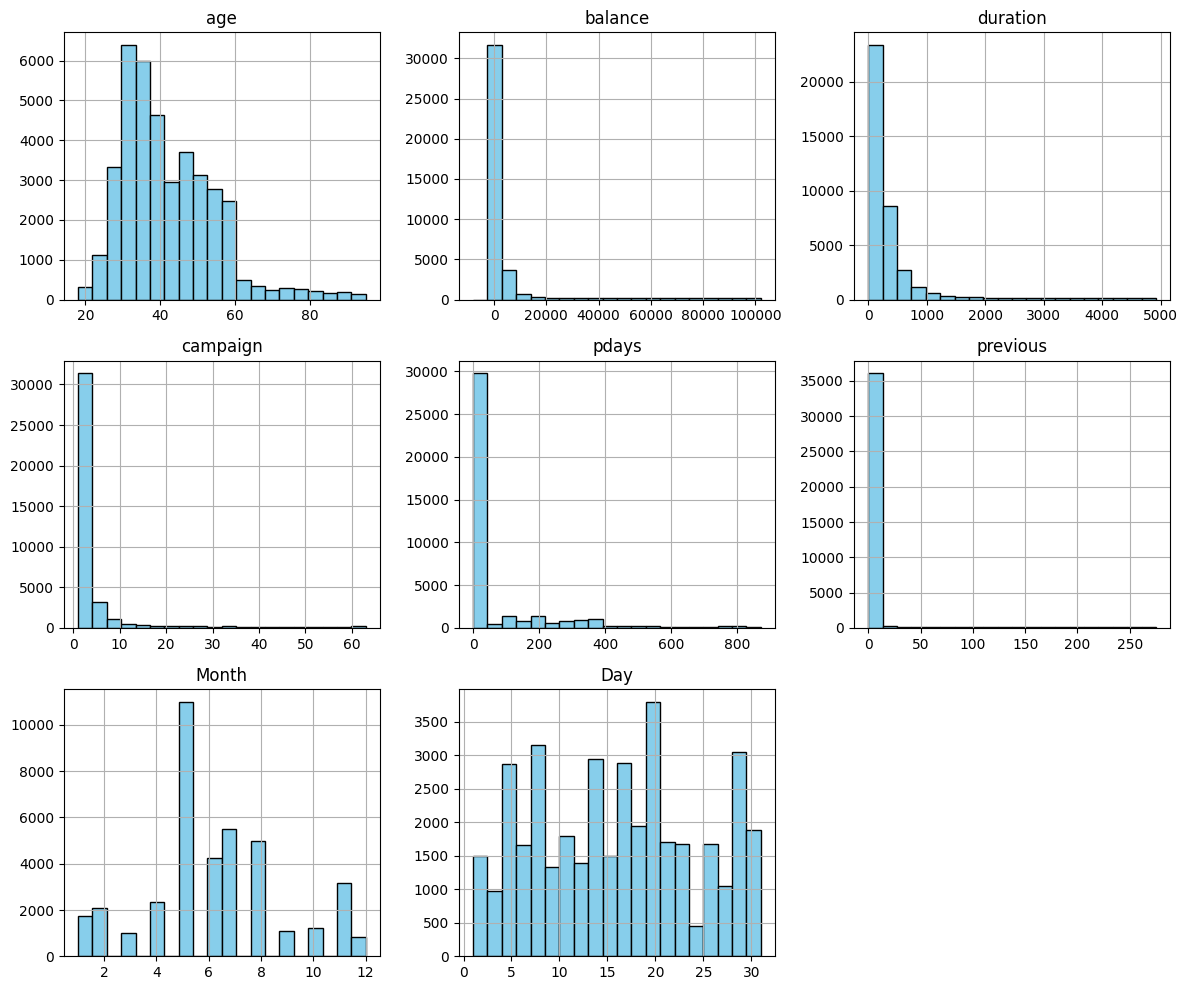

In [15]:
#Histogram of Numeric Columns
train_df[numeric_columns].hist(figsize=(12,10),bins=20,color='skyblue',edgecolor='black')
plt.tight_layout()
plt.show()

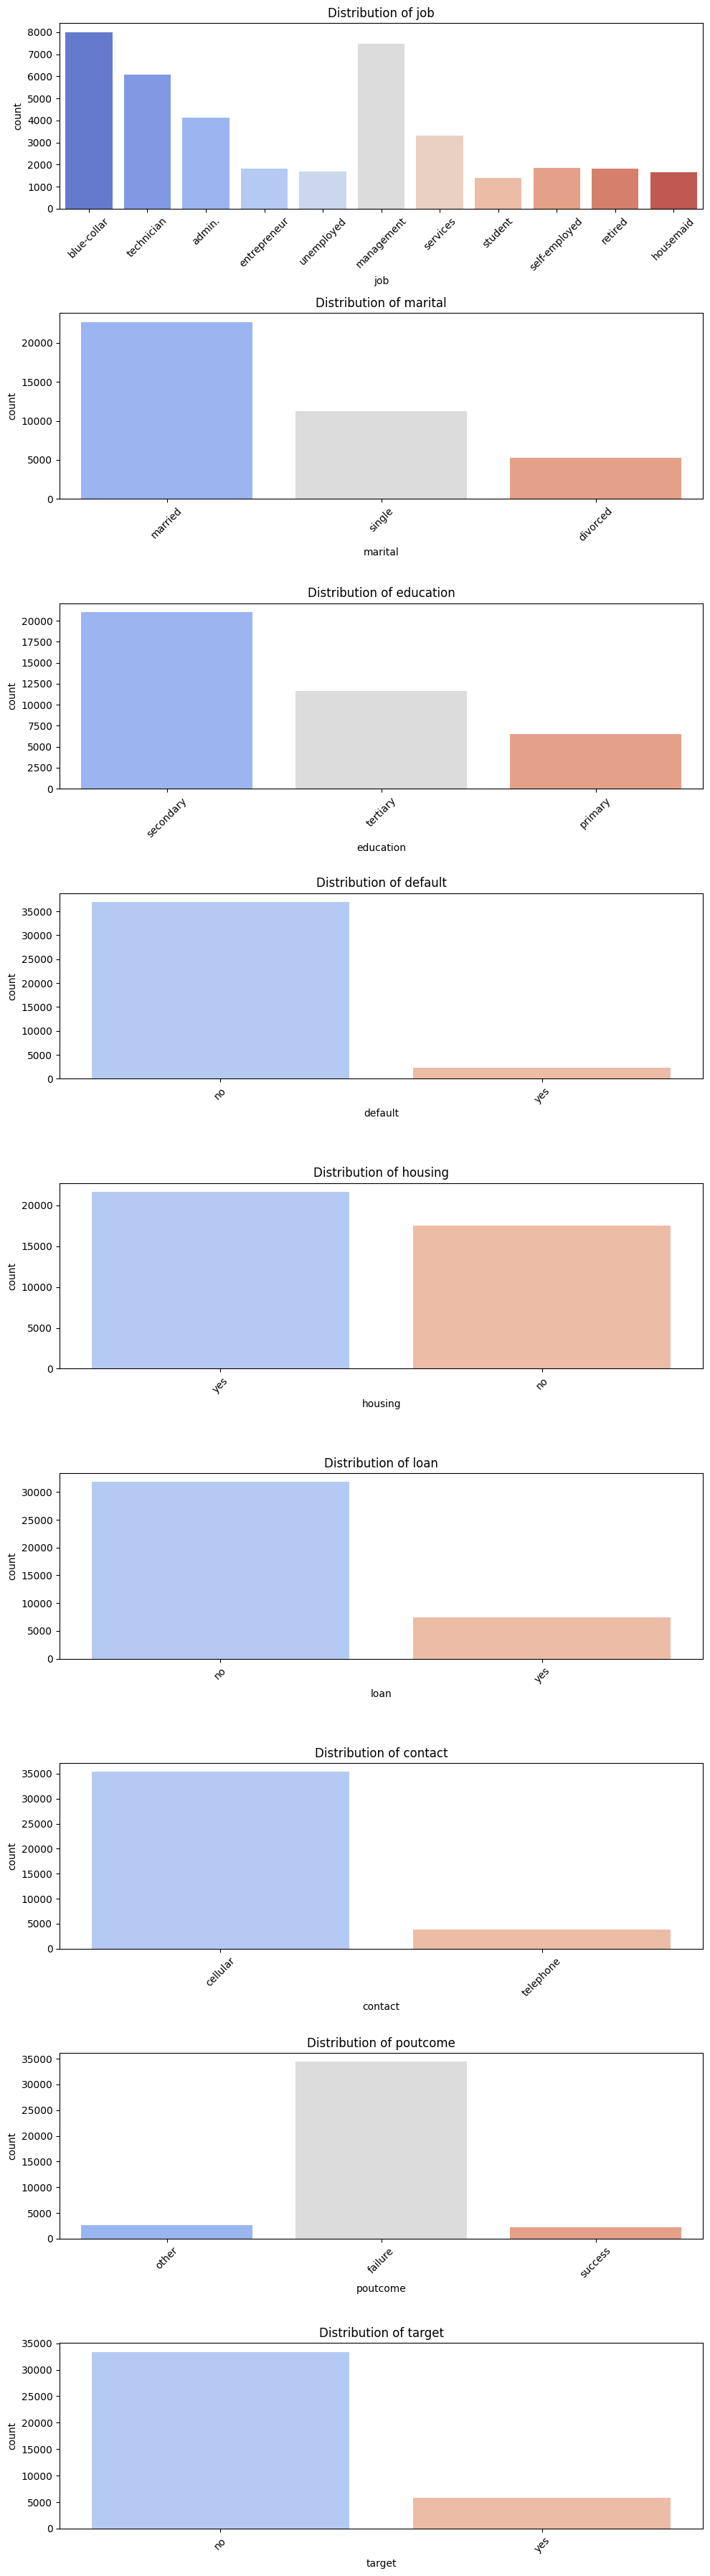

In [16]:
#BarPlots of Categorical Columns
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(10, 4 * len(categorical_columns)))

for i, column in enumerate(categorical_columns):
    sns.countplot(data=train_df, x=column, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

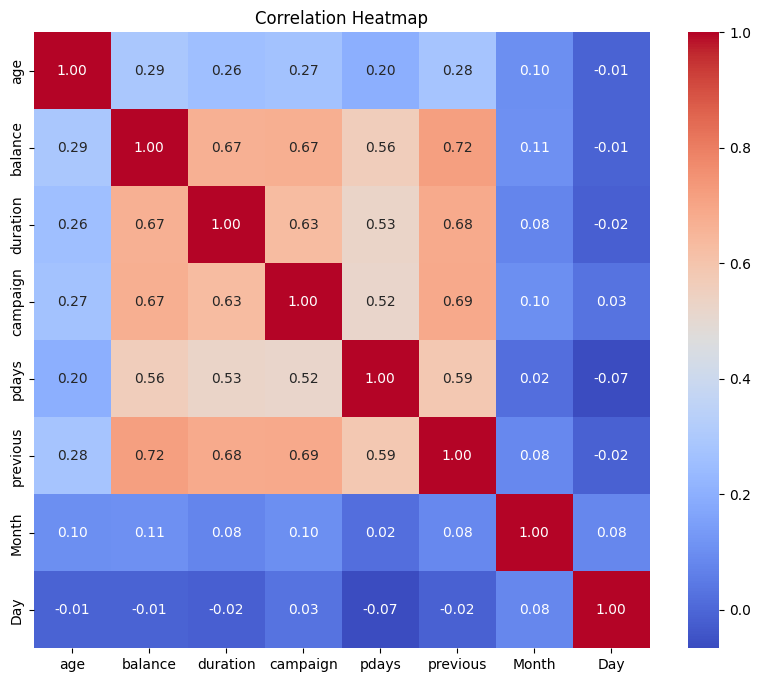

In [17]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

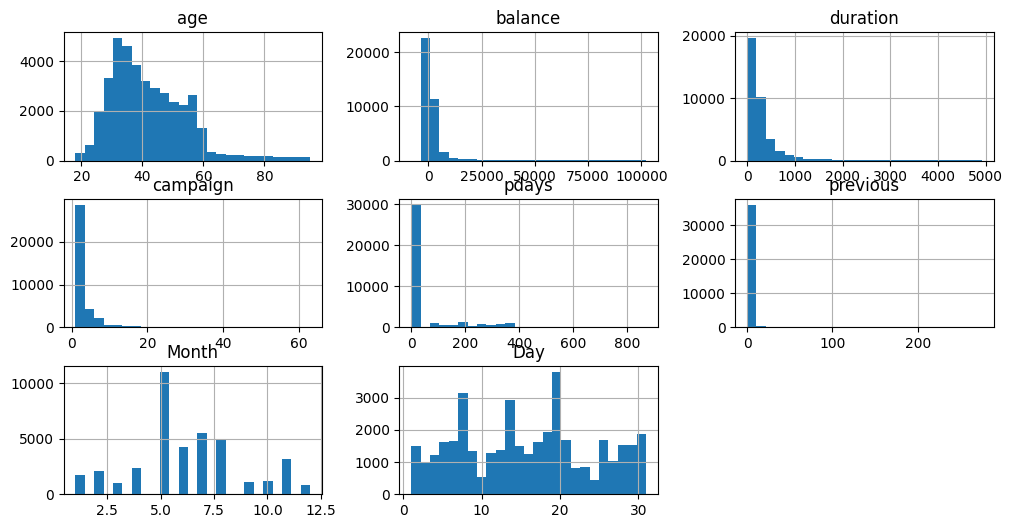

In [18]:
train_df.hist(bins=25, figsize=(12, 6))
plt.show()

# Spliting the Dataset

In [19]:
x = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Check the distribution of classes in train and test sets
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("\nTest target distribution:\n", y_val.value_counts(normalize=True))

Train target distribution:
 target
no     0.851409
yes    0.148591
Name: proportion, dtype: float64

Test target distribution:
 target
no     0.851332
yes    0.148668
Name: proportion, dtype: float64


# Encoding and Scaling the Features

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def add_onehot_to_dataframe(sparse, df, vectorizer, name):
  '''
      This function will add the one hot encoded to the dataframe.

  '''
  for i, col in enumerate(vectorizer.get_feature_names_out()):
    colname = name+"_"+col
    # df[colname] = pd.SparseSeries(sparse[:, i].toarray().flatten(), fill_value=0)
    df[colname] = sparse[:, i].toarray().ravel().tolist()

  return df

def OneHotEncoder(categorical_cols, X_train, X_test, X_cv=None, include_cv=False):
  '''
    This function takes categorical column names as inputs. The objective
    of this function is to take the column names iteratively and encode the
    features using One hot Encoding mechanism and also adding the encoded feature
    to the respective dataframe.

    The include_cv parameter indicates whether we should include CV dataset or not.
    This is added specifically because when using GridSearchCV or RandomizedSearchCV,
    we only split the dataset into train and test to give more data to training purposes.
    This is done because GridSearchCV splits the data internally anyway.
  '''

  for i in categorical_cols:
    Vectorizer = CountVectorizer(token_pattern="[A-Za-z0-9-.]+")
    print("Encoding for feature: ", i)
    # Encoding training dataset
    temp_cols = Vectorizer.fit_transform(X_train[i])
    X_train = add_onehot_to_dataframe(temp_cols, X_train, Vectorizer, i)

    # Encoding Cross validation dataset
    if include_cv:
      temp_cols = Vectorizer.transform(X_cv[i])
      X_cv = add_onehot_to_dataframe(temp_cols, X_cv, Vectorizer, i)

    # Encoding Test dataset
    temp_cols = Vectorizer.transform(X_test[i])
    X_test = add_onehot_to_dataframe(temp_cols, X_test, Vectorizer, i)


In [22]:
numeric_columns = x_train.select_dtypes(include=["int64","int32"]).columns.to_list()
categorical_columns = (x_train.select_dtypes(include="object").columns.to_list())
numeric_columns,categorical_columns

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'Month',
  'Day'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome'])

In [23]:
OneHotEncoder(categorical_columns, x_train, x_val)

# Drop the categorical features as the one hot encoded representation is present
x_train = x_train.drop(categorical_columns, axis=1)
# X_cv = X_cv.drop(categorical_cols, axis=1)
x_val = x_val.drop(categorical_columns, axis=1)

print("Shape of train: ", x_train.shape)
# print("Shape of CV: ", X_cv.shape)
print("Shape of test: ", x_val.shape)

Encoding for feature:  job
Encoding for feature:  marital
Encoding for feature:  education
Encoding for feature:  default
Encoding for feature:  housing
Encoding for feature:  loan
Encoding for feature:  contact
Encoding for feature:  poutcome
Shape of train:  (31368, 36)
Shape of test:  (7843, 36)


In [24]:
cols = (x_train.columns).tolist()
cols

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'Month',
 'Day',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success']

In [25]:
numeric_columns = x_train.select_dtypes(include=["int64","int32"]).columns.to_list()
categorical_columns = x_train.select_dtypes(include="object").columns.to_list()
numeric_columns,categorical_columns

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'Month',
  'Day',
  'job_admin.',
  'job_blue-collar',
  'job_entrepreneur',
  'job_housemaid',
  'job_management',
  'job_retired',
  'job_self-employed',
  'job_services',
  'job_student',
  'job_technician',
  'job_unemployed',
  'marital_divorced',
  'marital_married',
  'marital_single',
  'education_primary',
  'education_secondary',
  'education_tertiary',
  'default_no',
  'default_yes',
  'housing_no',
  'housing_yes',
  'loan_no',
  'loan_yes',
  'contact_cellular',
  'contact_telephone',
  'poutcome_failure',
  'poutcome_other',
  'poutcome_success'],
 [])

In [26]:
# encoder = OrdinalEncoder()
# x_train_cat = pd.DataFrame(encoder.fit_transform(x_train[categorical_columns]),columns = categorical_columns)
# x_val_cat = pd.DataFrame(encoder.fit_transform(x_val[categorical_columns]),columns = categorical_columns)

# x_train_num = x_train.drop(categorical_columns, axis=1)
# x_val_num = x_val.drop(categorical_columns, axis=1)

# # Concatenate the encoded categorical columns with the numerical columns
# x_train_coded = pd.concat([x_train_num.reset_index(drop=True), x_train_cat.reset_index(drop=True)], axis=1)
# x_val_coded = pd.concat([x_val_num.reset_index(drop=True), x_val_cat.reset_index(drop=True)], axis=1)
# print(x_train_coded)
# # print(x_test_final.head(5))

In [27]:
# scaler = StandardScaler()
# x_train = pd.DataFrame(scaler.fit_transform(x_train_coded),columns = x_train.columns)
# x_val = pd.DataFrame(scaler.fit_transform(x_val_coded),columns=x_val.columns)
# x_train

# Feature Selection

In [28]:
cols = (x_train.columns).tolist()
cols

['age',
 'balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'Month',
 'Day',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success']

In [29]:
x_train

,age,balance,duration,campaign,pdays,previous,Month,Day,job_admin.,job_blue-collar,...,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
11002,35,6809,139,8,273,7,2,6,0,0,...,0,0,1,1,0,0,1,1,0,0
16008,54,384,200,1,-1,0,5,27,0,0,...,0,1,0,0,1,1,0,1,0,0
24722,21,216,414,1,-1,0,8,5,0,0,...,0,1,0,1,0,1,0,1,0,0
1722,32,12269,141,1,-1,0,5,16,0,0,...,0,1,0,1,0,1,0,1,0,0
21374,41,-62,55,2,-1,0,5,5,1,0,...,0,0,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8964,52,428,153,1,-1,0,5,30,0,0,...,0,0,1,1,0,1,0,1,0,0
23322,28,13505,1143,28,708,84,1,8,0,0,...,0,0,1,0,1,1,0,0,1,0
3638,37,1580,92,12,-1,0,8,22,0,0,...,0,1,0,1,0,1,0,1,0,0
20677,28,423,245,1,-1,0,7,23,1,0,...,0,0,1,1,0,1,0,1,0,0


In [30]:
x_train = pd.DataFrame(x_train,columns=cols)

# Building and training the model
model3 = RandomForestClassifier(random_state = 42)
selector = RFE(model3, n_features_to_select=10)
# x_train = selector.fit_transform(x_train, y_train)
selector.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)

In [31]:
selected_features_mask = selector.get_support()

# Get the list of selected feature names
selected_features = x_train.columns[selected_features_mask]
print("Selected features:", selected_features.tolist())


Selected features: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'Month', 'Day', 'poutcome_failure', 'poutcome_success']


In [32]:
X_val = x_val[selected_features]
X_train = x_train[selected_features]

# Creating ML Models and making Predictinos

In [33]:
# Building and training the model
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
# Making predictions
pred = model.predict(X_val)
pred

# Evaluating the model
f1 = f1_score(y_val,pred, average='macro')
print(f'F1 Score of the baseline model: {f1}')

F1 Score of the baseline model: 0.5762496771302106


In [35]:
# Building and training the model
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [36]:
pred2 = model2.predict(X_val)
pred2
# Evaluating the model
f1 = f1_score(y_val,pred2, average='macro')
print(f'F1 Score of the baseline model: {f1}')

F1 Score of the baseline model: 0.6903777102672092


In [37]:
# Building and training the model
model3 = RandomForestClassifier(random_state = 42)
model3.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
pred3 = model3.predict(X_val)
pred3
# Evaluating the model
f1 = f1_score(y_val,pred3, average='macro')
print(f'F1 Score of the baseline model: {f1}')

F1 Score of the baseline model: 0.7199307948041187


In [39]:
y_train = y_train.replace({'yes': 1, 'no': 0})
y_val = y_val.replace({'yes': 1, 'no': 0})

/tmp/ipykernel_30/864118255.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'yes': 1, 'no': 0})
/tmp/ipykernel_30/864118255.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'yes': 1, 'no': 0})


In [40]:
# Initialize the XGBoost model with basic parameters
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_val)

# Evaluate the model
xgb_f1 = f1_score(y_val, xgb_pred, average='macro')
print(f'XGBoost F1 Score: {xgb_f1}')

XGBoost F1 Score: 0.7308972379481902


In [41]:
# Initialize the LightGBM model with basic parameters
lgb_model = LGBMClassifier(random_state=42)

# Fit the model
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_pred = lgb_model.predict(X_val)

# Evaluate the model
lgb_f1 = f1_score(y_val, lgb_pred, average='macro')
print(f'LightGBM F1 Score: {lgb_f1}')

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
LightGBM F1 Score: 0.7318174988344596


In [42]:
# from sklearn.metrics import roc_auc_score

# # ---- Train LightGBM ----
# lgb_model = LGBMClassifier(random_state=42)
# lgb_model.fit(X_train, y_train)
# lgb_preds = lgb_model.predict(x_test)

# # ---- Train XGBoost ----
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# xgb_model.fit(X_train, y_train)
# xgb_preds = xgb_model.predict(x_test)

# # ---- Blend Predictions ----
# blended_preds = (lgb_preds + xgb_preds ) / 2

# Evaluate the blended model
# roc_auc = roc_auc_score(y_val, blended_preds)
# print(f"Blended Model ROC-AUC Score: {roc_auc:.4f}")

In [43]:
# # Convert probabilities to binary labels
# blended_labels = (blended_preds >= 0.5).astype(int)

# # Check value counts of binary labels
# s = pd.Series(blended_labels)
# print(s.value_counts())

In [44]:
# pred3 = model3.predict(X_val)
# pred3
# # Evaluating the model
# f1 = f1_score(y_val,pred3, average='macro')
# print(f'F1 Score of the baseline model: {f1}')

In [45]:
# from sklearn.feature_selection import RFECV

# # Instantiate RFECV
# rfecv = RFECV(estimator=model3, step=1, cv=5, scoring='f1_macro')
# rfecv.fit(X_train, y_train)

# # Optimal number of features
# print(f"Optimal number of features: {rfecv.n_features_}")

In [46]:
# from sklearn.model_selection import cross_val_score

# scores = []

# # Try different values of n_features_to_select
# for n in range(5, len(x_train.columns), 2):  # or set your preferred step
#     selector = RFE(model3, n_features_to_select=n)
#     X_train_selected = selector.fit_transform(x_train, y_train)

#     # Perform cross-validation
#     cv_score = cross_val_score(model3, X_train_selected, y_train, cv=5, scoring='f1_macro')
#     scores.append((n, np.mean(cv_score)))

# # Choose the n with the best score
# best_n, best_score = max(scores, key=lambda item: item[1])
# print(f"Best number of features: {best_n}, F1 Score: {best_score}")


In [47]:
# selector = RFE(model3, n_features_to_select=8)
# # x_train = selector.fit_transform(x_train, y_train)
# selector.fit(x_train, y_train)

In [48]:
# selected_features_mask = selector.get_support()

# Get the list of selected feature names
# select_features = x_train.columns[rfecv.support_]
# print("Selected features:", selected_features.tolist())

In [49]:
# # Assuming X_test is a DataFrame with the same original feature names as X_train
# X_test = X_test[selected_features]
# x_train = x_train[selected_features]

In [50]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.95, random_state=42)
# x_train_pca = pca.fit_transform(x_train)
# x_test_pca = pca.transform(x_val)

# print(f"Number of components selected by PCA: {x_train_pca.shape[1]}")

In [51]:
# # Step 3: Train the model on the transformed data
# model4 = RandomForestClassifier(random_state=42)
# model4.fit(x_train_pca, y_train)

In [52]:
# model3.fit(x_train, y_train)

In [53]:
# from sklearn.metrics import f1_score

# pred4 = model4.predict(x_test_pca)

# # Evaluating the model
# f1 = f1_score(y_val,pred4, average='macro')
# print(f'F1 Score of the baseline model: {f1}')

In [54]:
# s = pd.Series(pred3)
# s.value_counts()

In [55]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [200, 300],          # Number of trees in the forest
#     'max_depth': [10, 20],              # Maximum depth of trees
#     'min_samples_split': [5,10],              # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2],               # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt'],         # Number of features to consider for the best split
#     'bootstrap': [False],               # Whether bootstrap samples are used
#     'random_state': [42]                      # Set a fixed random state for reproducibility
# }

# # Initialize RandomizedSearchCV with reduced hyperparameter space
# random_search = RandomizedSearchCV(
#     estimator=RandomForestClassifier(),
#     param_distributions=param_grid,
#     n_iter=100,                # 100 different random combinations
#     cv=3,                      # Reduced from 5 to 3 for faster cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1,
#     scoring='f1_macro'         # Using f1_macro as the evaluation metric
# )

# # Fit the random search model
# random_search.fit(X_train, y_train)

In [56]:
# # Find the best parameters
# best_params = random_search.best_params_
# print(f'Best Parameters: {best_params}')

In [57]:
# # Predict using the tuned model
# best_rf_model = random_search.best_estimator_
# y_pred_rf = best_rf_model.predict(X_test)
# y_pred_rf
# # Convert numeric predictions to 'yes'/'no'
# # y_pred_rf_label = encoder.inverse_transform(y_pred_rf)
# # y-pred_rf

In [58]:
# s = pd.Series(y_pred_rf)
# s.value_counts()

In [59]:
# # Building and training the model
# model4 = GaussianNB()
# model4.fit(x_train, y_train)

In [60]:
# pred4 = model4.predict(X_test)
# pred4
# # Evaluating the model
# f1 = f1_score(Y_test,pred4, average='macro')
# print(f'F1 Score of the baseline model: {f1}')

In [61]:
# s = pd.Series(pred4)
# s.value_counts()

# Predicting on the Test Set

In [62]:
test_df

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,Month,Day
0,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN,11,21
1,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN,2,4
2,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN,7,28
3,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN,6,9
4,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,NaN,11,20
9996,26,admin.,single,secondary,no,317,yes,no,NaN,953,1,-1,0,NaN,6,3
9997,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,NaN,4,20
9998,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,NaN,2,17


In [63]:
numeric_columns = test_df.select_dtypes(include=["int64","int32"]).columns.to_list()
categorical_columns = test_df.select_dtypes(include="object").columns.to_list()
numeric_columns,categorical_columns

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'Month',
  'Day'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome'])

In [64]:
# Filling missing values for categorical columns with mode
for column in categorical_columns:
    test_df[column].fillna(test_df[column].mode()[0], inplace=True)

# Filling missing values for numerical columns with mean
for column in numeric_columns:
    test_df[column].fillna(test_df[column].mean(),inplace=True)

/tmp/ipykernel_30/2347994146.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[column].fillna(test_df[column].mode()[0], inplace=True)
/tmp/ipykernel_30/2347994146.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [65]:
# test_df['Year'] =test_df['last contact date'].dt.year
# test_df['Month'] = test_df['last contact date'].dt.month
# test_df['Day'] = test_df['last contact date'].dt.day

# # Extracting binary features for 'Weekday' and 'Weekend'
# test_df['Weekday'] = test_df['last contact date'].dt.weekday  # 0 = Monday, 6 = Sunday
# test_df['Weekend'] = test_df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for Saturday and Sunday, else 0

# # Drop the original 'last contact date' if not needed anymore
# test_df = test_df.drop(columns=['last contact date'])

# # Display the first few rows to verify the new columns
# print(test_df.head())

In [66]:
numeric_columns = test_df.select_dtypes(include=["int64","int32"]).columns.to_list()
categorical_columns = test_df.select_dtypes(include="object").columns.to_list()
numeric_columns,categorical_columns

(['age',
  'balance',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'Month',
  'Day'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'poutcome'])

In [67]:
test_df

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,Month,Day
0,36,management,single,tertiary,no,7,no,no,cellular,20,1,-1,0,failure,11,21
1,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,failure,2,4
2,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,failure,7,28
3,38,admin.,married,primary,no,1487,no,no,cellular,332,2,-1,0,failure,6,9
4,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,38,management,single,tertiary,no,8953,no,yes,cellular,301,1,-1,0,failure,11,20
9996,26,admin.,single,secondary,no,317,yes,no,cellular,953,1,-1,0,failure,6,3
9997,26,technician,single,secondary,no,181,no,no,cellular,158,2,-1,0,failure,4,20
9998,32,management,single,tertiary,no,312,no,no,cellular,232,2,-1,0,failure,2,17


In [68]:
# x_test = test_df.drop(['Year','Weekday','Weekend'],axis=1)
# x_test

In [69]:
# encoder = OrdinalEncoder()
# # x_train_cat = pd.DataFrame(encoder.fit_transform(x_train[categorical_columns]),columns = categorical_columns)
# x_test_cat = pd.DataFrame(encoder.fit_transform(x_test[categorical_columns]),columns = categorical_columns)

# # x_train_num = x_train.drop(categorical_columns, axis=1)
# x_test_num = x_test.drop(categorical_columns, axis=1)

# # Concatenate the encoded categorical columns with the numerical columns
# # x_train_coded = pd.concat([x_train_num.reset_index(drop=True), x_train_cat.reset_index(drop=True)], axis=1)
# x_test_coded = pd.concat([x_test_num.reset_index(drop=True), x_test_cat.reset_index(drop=True)], axis=1)
# print(x_test_coded)
# # print(x_test_final.head(5))

In [70]:
# scaler = StandardScaler()
# x_train = pd.DataFrame(scaler.fit_transform(x_train_coded),columns = x_train.columns)
# x_test = pd.DataFrame(scaler.fit_transform(x_test_coded),columns=x_test.columns)
# x_test

In [71]:
test_2 = test_df.copy()
test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        10000 non-null  int64 
 1   job        10000 non-null  object
 2   marital    10000 non-null  object
 3   education  10000 non-null  object
 4   default    10000 non-null  object
 5   balance    10000 non-null  int64 
 6   housing    10000 non-null  object
 7   loan       10000 non-null  object
 8   contact    10000 non-null  object
 9   duration   10000 non-null  int64 
 10  campaign   10000 non-null  int64 
 11  pdays      10000 non-null  int64 
 12  previous   10000 non-null  int64 
 13  poutcome   10000 non-null  object
 14  Month      10000 non-null  int32 
 15  Day        10000 non-null  int32 
dtypes: int32(2), int64(6), object(8)
memory usage: 1.1+ MB


In [72]:
OneHotEncoder(categorical_columns, test_2,test_df)

# Drop the categorical features as the one hot encoded representation is present
test_2 = test_2.drop(categorical_columns, axis=1)
# X_cv = X_cv.drop(categorical_cols, axis=1)
x_test = test_df.drop(categorical_columns, axis=1)

# print("Shape of train: ", x_train.shape)
# print("Shape of CV: ", X_cv.shape)
print("Shape of test: ", x_test.shape)

Encoding for feature:  job
Encoding for feature:  marital
Encoding for feature:  education
Encoding for feature:  default
Encoding for feature:  housing
Encoding for feature:  loan
Encoding for feature:  contact
Encoding for feature:  poutcome
Shape of test:  (10000, 36)


10 (n_features_to_select) is the best as of now through RFE

In [73]:
x_test = x_test[selected_features]

In [74]:
# Define SMOTE for oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Build a pipeline to apply SMOTE and then fit the model
pipeline = Pipeline([
    ('smote', smote),  # SMOTE for oversampling the minority class
    ('clf',LGBMClassifier())  # RandomForest or any other classifier
])

# Train the model on the oversampled data
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 26707, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 53414, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('clf', LGBMClassifier())])

In [75]:
prediction = pipeline.predict(x_test)
s = pd.Series(prediction)
s.value_counts()

0    7507
1    2493
Name: count, dtype: int64

In [ ]:
# Define the hyperparameter grid for LightGBM
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 10, -1],  # -1 means no limit
    'clf__num_leaves': [31, 50, 100],
    'clf__min_data_in_leaf': [20, 30, 50],
    'clf__subsample': [0.6, 0.8, 1.0],  # Fraction of data used for training
    'clf__colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used for training
}

# Perform Grid Search with Cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (f1_macro): {grid_search.best_score_}")

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 21365, number of negative: 21365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 42730, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_sample

In [ ]:
# Assuming you've already done GridSearchCV or RandomizedSearchCV as shown before
best_model = grid_search.best_estimator_

# Retrain on the entire training dataset (if needed)
best_model.fit(X_train, y_train)



In [ ]:
import pickle

# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Load the model later (if needed)
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)


In [ ]:
prediction = best_model.predict(x_test)
s = pd.Series(prediction)
s.value_counts()

In [ ]:
# Convert the prediction array to a Pandas Series, replace values, then back to a NumPy array
result = pd.Series(prediction).replace({1: 'yes', 0: 'no'}).to_numpy()

# Display the result
print(result)

# Creating Submission File

In [ ]:
# Load the sample submission file to understand its structure
sample_submission = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

# Assuming the sample_submission has a 'target' column for predictions
# Replace the 'target' column with your model's predictions (pred)
sample_submission['target'] = result
# Save the updated submission file
submission_file_path = '/kaggle/working/submission.csv'
sample_submission.to_csv(submission_file_path, index=None)

print(f'Submission file saved to: {submission_file_path}')